# Tomography walkthrough
This notebook performs analysis of tomography data from the raw data tilt series to the fully aligned tilt stack and finally a tomographic reconstruction at the end. The general process is:
- Import data and format it correctly
- Rough alignment of the image shifts within the stack
- Fine alignment of image shifts within the stack
- Alignment of the tilt axis
- Tomographic reconstruction
- (Visualisation)
- Calibration

## How to use this notebook
- There are several sections to the notebook (Stack generation, Align stack, Fine alignment, Align axis and Reconstruction). 
    - You can either go through all in one session or save your dataset at the end of a section and use that as the input for the next session whenever you like.
    - The full process can take anywhere from 20 minutes to 2+ hrs depending on the dataset and desired resolution.
    - The first cell in each section will import the necessary modules for that section.
- Handy shortcuts:
    - 'Ctrl' + 'Enter' will run the code in a cell
    - 'Shift' + 'Enter' will run the code in a cell and move to the next cell
    - Position the cursor inside the parentheses after a function, hold 'Shift' and tap 'Tab' once/twice to see basic/extended function help details respectively.
    - Plots appear 'inline' (i.e. embedded into the page) by default but you can make them appear in a new window by running the code '%matplotlib qt' (switch back by running '%matplotlib inline'.
    - To comment out a large section of code, highlight it and press 'Ctrl' + '/', undo it with the same command.
- Loading data:
    - Filepaths should either be relative to the folder where this script is saved (eg 'subfolder/mydata.hdf5') or global (eg 'home/user/subfolder/mydata.hdf5' or C:/user/subfolder/mydata.hdf5 depending on operating system)
    - The hyperspy load function should recognise raw .mrc files but can also load .tif stacks and its own .hdf5 file format.
    - If you use \ instead of / then it is fine except that certain expressions like \t \n and \r are special commands in python - to avoid the backslash being interpreted in this way, place an 'r' in front of the string.

In [1]:
# imports
# qt or inline swaps plotting style
%matplotlib qt 
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import copy
import astra

from skimage.feature import register_translation
from skimage.filters import prewitt, median, sobel, gabor, gaussian
from skimage import feature
from skimage.morphology import disk, square
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
import skimage as sk
import pandas as pd

import sys; sys.path.append(r"C:\Users\Sauron\Documents\Tomography demo");
import RegTomoRecon as rtr

Using matplotlib backend: Qt5Agg
Compilation successful


# Stack generation
Import the desired data and put it into a usable stack. This involves loading it as a hyperspy object, rescaling intensities to lie between 0 and 1. Data binning, cropping, data 'cleaning' and rotation should also be done here if needed.

- Import necessary modules. Hyperspy is a key package developed for manipulation of electron microscope data - extensive documentation and citation information can be found [here](http://hyperspy.org/hyperspy-doc/current/citing.html).

- Load data from file

In [2]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = r'raw_data_tiff.tif'
fpath = folder+name
s = hs.load(fpath)

- Plot the data and check its shape - these function will be useful throughout the script

In [3]:
s.plot()
s.data.shape

(101, 2048, 2048)

- Remove any images obscured by support

In [4]:
s = hs.signals.Signal2D(s.data[:-2]) # slice off last 2 images
s.plot()

- Run this cell to rebin the data. Binning the data may make analysis faster but with a cost in resolution.

In [5]:
# each pixel in the new spectrum will be 4x the size of the pixels in the old spectrum
s = s.rebin(scale=(1,4,4)) 

- Rotate the image if necessary (we need a vertical axis of rotation)

In [6]:
s = hs.signals.Signal2D(np.transpose(s,axes=[2,1,0])) # Rotate 90 degrees (ie shift x and y axes)

In [7]:
s.plot()

- Crop data if necessary (processing will be faster for smaller images) - but make sure to leave some buffer room for axis alignment later)

In [8]:
# Deepcopy should make it easy to adjust the cropping without messing up the original image
scopy = copy.deepcopy(s)

# top, bottom, left, right
scopy.crop_image(0,300,0,400)
scopy.plot()

In [9]:
s = copy.deepcopy(scopy)

In [10]:
s.plot()

- Rescale intensity range 0 to 1, this will help with the eventual reconstruction

In [11]:
s.data = (s.data-s.data.min())/np.max(s.data-s.data.min())

- Save output if desired

In [12]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'initial_clean.hdf5'

In [13]:
s.save(folder+name)

Overwrite 'C:\Users\Sauron\Documents\Tomography demo\\initial_clean.hdf5' (y/n)?
 y


# Align stack
This section will align the images in the stack such that there is minimal shift between tilts. Initially a 'rough' method using phase correlation will be performed and subsequently an iterated correlation using filters will be used for fine adjustments.

- Load dataset if necessary and check how it looks

In [21]:
#s = hs.load(folder+name)

In [14]:
s.plot()
s.data.shape

(99, 300, 400)

## Rough alignment
- Estimages image shifts using phase correlation
- Play with changing the reference type to try and improve alignment
- Sobel filtering enhances the edges of the image to aid with alignment, but is not always appropriate so can be turned to False

In [15]:
# work on a copy in case anything goes wrong
scopy = copy.deepcopy(s)

rough_shifts = scopy.align2D(shifts=None, reference='cascade',crop=True, sobel=True) 
# Reference can be 'current', 'cascade' (compares to previous), 'stat' compares all statistically

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [16]:
scopy.plot()

In [17]:
# update signal from copied signal
s = copy.deepcopy(scopy)

## Fine alignment
- We will now apply sobel (edge-finding) filters to the data and use a Han Window to smooth the data and also to downweight high frequency contributions. These filtered images are then phase-correlated to align the images. This is repeated several times until the images are well aligned.
- A short video explanation of how phase correlation works can be found on [Coursera](https://www.coursera.org/lecture/digital/phase-correlation-a60Ui) but essentially it uses the Fourier shift theorem which in this context says that the FT of a translated image is related to the FT of the non-translated image by a phase factor $e^\phi$. We can then exploit this to align the images to sub-pixel precision.

- Here we will generate a (single) filtered image and plot it just for reference.

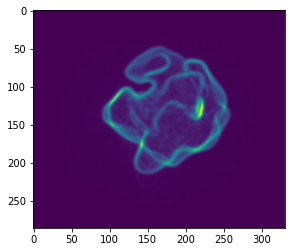

In [18]:
%matplotlib inline

ref = gaussian(sobel(s.data[2,:,:]),1.5)
im = gaussian(sobel(s.data[3,:,:]),1.5)
h0= np.hanning(np.size(ref,0))
h1= np.hanning(np.size(ref,1))
hann2d = np.sqrt(np.outer(h0,h1))
ref= hann2d*ref
im = hann2d*im

plt.imshow(ref)

- Now we calculate the shift between a single (filtered) image and its (filtered) reference (note that the reference is just the previous image in the stack).

In [19]:
shift, error, diffphase = register_translation(ref,im, 100)

C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


- Now we plot the filtered image, its reference, and the phase correlation map - just to see what the algorithm is doing.

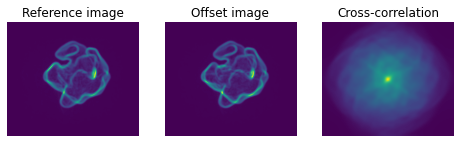

In [20]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1, adjustable='box')
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1, adjustable='box')
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(ref)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(im)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Multiply the Fourier transforms of the image and reference
# Shift the image product so that the zero-frequency component is at the centre
image_product = np.fft.fft2(ref) * np.fft.fft2(im).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

- Now calculate the shifts for all images in the stack, using processes demonstrated above (this is the first iteration).

In [21]:
numTilts = np.size(s.data,0)
shiftList = np.zeros((numTilts,2))
for sl in np.arange(0,numTilts-1):
    ref = gaussian(sobel(s.data[sl,:,:]),1.5) # reference is sobel filter of previous image
    im = gaussian(sobel(s.data[sl+1,:,:]),1.5) # sobel of current image
    h0= np.hanning(np.size(ref,0)) # A Hann window is applied to smooth signals, particularly the start and end
    h1= np.hanning(np.size(ref,1))
    hann2d = np.sqrt(np.outer(h0,h1)) # Create a 2D Hann window
    ref = hann2d*ref # Reference becomes Hann Smoothed Sobel signal
    im = hann2d*im # Image is also Han smoothed
    shift, error, diffphase = register_translation(ref,im, 200) # Calculate shift between image and reference
    shiftList[sl+1,:] = shift # Add shift to the list

C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

- We now need to calculate the 'universal' shifts (since the alignment is cascade style, the shifts calculated by the cell above are all relative to the previous image in the stack, rather than to the first image).

In [22]:
AltShiftList = np.zeros_like(shiftList)

AltShiftList[0,:] = shiftList[0,:]

for sl in np.arange(0,numTilts-1):
    AltShiftList[sl+1,:] = np.sum(shiftList[0:sl+2,:],axis=0)
    
num_iter = 1
TotShift=AltShiftList
All_shifts = [AltShiftList]

- Apply calculated shifts to the data and plot it.

In [23]:
%matplotlib qt

sAlig = s.deepcopy()
sAlig.align2D(shifts=-1*(AltShiftList)) 
sAlig.plot()

  0%|          | 0/99 [00:00<?, ?it/s]

- The following cell will automatically iterate through the full alignment process
- Run this cell as many times as necessary, using the following cell to check progress
- Typically three iterations will be pretty close, and six will be very well aligned

In [24]:
for x in range(6):
    shiftListCheck = np.zeros((numTilts,2))
    i = 0
    for sl in np.arange(0,numTilts-1):
        i += 1
        ref = sAlig.data[sl,:,:]
        im = sAlig.data[sl+1,:,:]
        h0= np.hanning(np.size(ref,0))
        h1= np.hanning(np.size(ref,1))
        hann2d = np.sqrt(np.outer(h0,h1))
        ref = hann2d*ref
        im = hann2d*im
        shift, error, diffphase = register_translation(ref,im, 200)
        shiftListCheck[sl+1,:] = shift
        if i % 10 == 0:
            print('Completed %s / %s' % (i, numTilts))

    AltShiftList = np.zeros_like(shiftListCheck)
    for sl in np.arange(0,numTilts-1):
        AltShiftList[sl+1,:] = np.sum(shiftListCheck[0:sl+2,:],axis=0)

    All_shifts.append(AltShiftList)

    TotShift = sum(All_shifts)
    sAlig = s.deepcopy()
    sAlig.align2D(shifts=-1*(TotShift))
    num_iter += 1
    print('This is iteration %s' % num_iter)


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 2


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 3


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 4


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 5


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 6


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 10 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 20 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 30 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 40 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 50 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 60 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 70 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 80 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

Completed 90 / 99


C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
C:\Users\Sauron\AppData\Roaming\Python\Python36\site-packages\skimage\feature\__init__.py:43: skimage_deprecation: Function ``register_t

  0%|          | 0/99 [00:00<?, ?it/s]

This is iteration 7


- Plot the calculated shifts for each iteration to see how it is changing and whether it seems to have converged or not

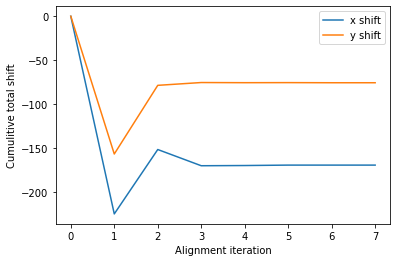

In [25]:
%matplotlib inline

mags = [[0],[0]]
for i in All_shifts:
    x_mag = sum(i[:,1])
    y_mag = sum(i[:,0])
    mags[0].append(mags[0][-1] + x_mag)
    mags[1].append(mags[1][-1] + y_mag)

plt.plot(mags[0], label='x shift')
plt.plot(mags[1], label='y shift')
plt.xlabel('Alignment iteration')
plt.ylabel('Cumulitive total shift')
plt.legend()

- Check that the alignment has worked visually

In [34]:
%matplotlib qt
sAlig.plot()

- Save shift-algined stack if desired

In [26]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'pixelshift_aligned.hdf5'

In [27]:
sAlig.save(folder+name)

# Align axis
- We next have to align the tilt axis so that it is both at the correct angle (vertical axis) and at the correct translation (centred)
- We do this by reconstructing 3 orthoslices (one near the top of the image, one centrally, and one near the bottom), by visually inspecting the sinograms we can determine whether an axis shift or rotation is necessary.
- The following figure demonstrates arcing in the sinogram of reconstructions with a misaligned axis, for the top and bottom slice: 
   - arcing in __same__ direction = incorrect axis shift 
   - arcing in __opposite__ directions = incorrect axis angle
<div>
<img src="https://lh3.googleusercontent.com/slf8iXyrXA-fgOoBVQL_DnNqmHmYp0vfjB-JdwnPPCFOG5QkFjfOsBMsKQBqHfA04EXolKmlMXwwTO559VShW436R6pIte5LyCL3-TuMQjG-G0m8Pu1gbeOqqMnEwbdHXGtikKXf6_T9KS76sKHmRZcpHHxcznaMWTXPVrNGHPJbHRO6YozhT7lI3sEwmEc9l8S6RTf7M7wbqUQHhsO9JMs3aVT6ROqI0D15IFmx8j50kwd3zHuEakZha7i2Tpz8HgVGqd6Cp140DVOiA03K6jZx0FDCKvIkds3mcQ8RwgJoIPHVuDZuotbCFX9q_tbtZnpcLI0UzcyBOoKyyet0ICthz0MpEjRwOMM2od4DOfSKDU1LQtEwLaUGfCCE1h72IJQY3kXD04fiD8LUQOHjT95U3EYAmF-o2YtI8L_JWWLfINjdd6f7vg9az5c0vL9sFbfTR5oZ2JedcwVd-efavcUDtMcBjvu2SZA1V4jXzcXi4d8HeVKOhWshUq1i_xr2qmuTLdHErQpdhL4JMM1KBwBnfJUFGdfRNqSbV2uK4e24io5KZalLt8NZJlyvBkBT7bEbljAdqH8S1DJUqPlEA6y0B_IUx7Cugh_MDr5F5CtN8fnii8Xbr4CtAK2e54X25sbLDH9EHni-OJ1dalTjw_y4I0lYFTot6Mq9k1EjVVARiHDtMJi2mTv2EV9dPnK1TQyjt8T1f_dGcWtRykPyJgmrgi8BiSgUy6s9HqJiNros3E14=w982-h937-no" width="500"/>
</div>
 <p style="text-align:center;"> Taken from Springer Handbook of Microscopy; Springer, 2019.


- Load/check data

In [ ]:
#s = hs.load(folder+name)

In [32]:
s=copy.deepcopy(sAlig)


In [29]:
s.plot()

In [37]:
np.shape(s)

(99, 279, 325)

# Import the acquisition angles in degrees

In [38]:
# Load tilts
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = r'tilt_file.rawtlt'
fpath=folder+name
df = pd.read_csv(fpath,header=None)
theta = df[0].values

#remove obscured tilts (match to start!)
theta = theta[:-2]

# check shapes and values
print(np.shape(s), np.shape(theta))
theta

(99, 279, 325) (99,)


array([-6.998e+01, -6.899e+01, -6.798e+01, -6.698e+01, -6.598e+01,
       -6.498e+01, -6.398e+01, -6.298e+01, -6.198e+01, -6.098e+01,
       -5.999e+01, -5.849e+01, -5.699e+01, -5.548e+01, -5.399e+01,
       -5.249e+01, -5.099e+01, -4.949e+01, -4.799e+01, -4.649e+01,
       -4.499e+01, -4.349e+01, -4.199e+01, -4.049e+01, -3.899e+01,
       -3.749e+01, -3.599e+01, -3.449e+01, -3.299e+01, -3.149e+01,
       -2.999e+01, -2.849e+01, -2.699e+01, -2.549e+01, -2.399e+01,
       -2.249e+01, -2.099e+01, -1.949e+01, -1.799e+01, -1.649e+01,
       -1.499e+01, -1.349e+01, -1.199e+01, -1.049e+01, -8.990e+00,
       -7.490e+00, -5.990e+00, -4.490e+00, -2.990e+00, -1.490e+00,
       -6.000e-02,  1.490e+00,  2.990e+00,  4.490e+00,  5.990e+00,
        7.490e+00,  8.990e+00,  1.049e+01,  1.199e+01,  1.349e+01,
        1.499e+01,  1.649e+01,  1.799e+01,  1.949e+01,  2.099e+01,
        2.249e+01,  2.399e+01,  2.549e+01,  2.699e+01,  2.849e+01,
        2.998e+01,  3.149e+01,  3.299e+01,  3.449e+01,  3.599e

- Format data so that it is compatible with the skimage radon function

In [39]:
sWork = s.deepcopy()

sWork.data = np.nan_to_num(sWork.data) # Replace nan with zero and infinity with large numbers if not already done
sWork.data = sWork.data/sWork.data.max() # Normalise data to 1 if not already done

# the iradon function requires the  0th index to be the axis of rotation
OriginalSinogram = np.transpose(sWork.data,axes=[1,2,0])
np.shape(OriginalSinogram)

(279, 325, 99)

- This cell allows you to adjust the rotation axis angle and shift.
- First adjust slice1, slice2 and slice3 so that they correspond to the y axis value of an image feature at the top, middle and bottom of the image respectively.
- Then adjust rotDegree (likely between -10 and +10 degrees) and shiftX (likely between -30 and +30 pixels) until you are satisfied that the axis is well aligned.
- It is easiest to adjust shiftX first until the central slice shows no arcing, then adjust the rotation angle until the top and bottom slices are also free from arcing (refer to image above for explanation).
- You will likely have to run the following cell several times, adjusting the parameters until you find the correct alignment.
- You may be able to estimate initial values for shiftX and rotDegree using imageJ or with clever guessing

In [50]:
from skimage.transform import iradon, AffineTransform, warp, rotate

for n in range(0,1):
    shiftX = 18 #-ve shifts right, +ve shifts left
    rotDegree= 0


    tilts = np.size(OriginalSinogram,2)

    tformTrans = AffineTransform(translation=(shiftX,0)) # An affine transformation preserves parallel lines
                                                        # in this case we are simply shifting along the x axis

    sinogram = np.zeros_like(OriginalSinogram)
    sinogram= warp(OriginalSinogram,tformTrans) # Transform coordinates according to given transformation
    sinogram = rotate(sinogram,rotDegree) # Rotate image arount its centre
    
    # The slice refers to which vertical plane of the image you wish to reconstruct
    # Choose slices which pass through a point of interest near the top, middle and bottom
    slice1 = 70#round(np.shape(sinogram)[0]/5)+30
    slice2 = 130#round(np.shape(sinogram)[0]/2)
    slice3 = 190#round(np.shape(sinogram)[0]*4/5) - 30
    print(slice1,slice2,slice3)
    filterName = 'shepp-logan' # Shepp-logan filter is a high pass filter (smoothed Ram-lak filter) 
                            # it will produce good contrast where the image changes quickly, but can let through noise
    
    # Perform inverse radon transform for each slice
    # Note that squeeze removes from an array any components with dimension 1
    reconstruction_fbp1 = iradon(sinogram[slice1,:,:].squeeze(), theta=theta, filter = filterName, circle=True)
    reconstruction_fbp2 = iradon(sinogram[slice2,:,:].squeeze(), theta=theta, filter = filterName, circle=True)
    reconstruction_fbp3 = iradon(sinogram[slice3,:,:].squeeze(), theta=theta, filter = filterName, circle=True)

    # Plot reconstructed slices
    fig, ax = plt.subplots(3, 1, figsize=(8.0, 20.0), sharex=True, sharey=True,
                          subplot_kw={'adjustable': 'box'})
    ax1, ax2, ax3 = ax.ravel()
    ax1.set_title("FBP1, rot %s, shift %s" % (rotDegree,shiftX))
    ax1.imshow(reconstruction_fbp1, cmap=plt.cm.Greys_r)

    ax2.set_title("FBP2")
    ax2.imshow(reconstruction_fbp2, cmap=plt.cm.Greys_r)

    ax3.set_title("FBP3")
    ax3.imshow(reconstruction_fbp3, cmap=plt.cm.Greys_r)

    plt.show()

70 130 190


C:\Users\Sauron\anaconda3\envs\cs_tomo\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
C:\Users\Sauron\anaconda3\envs\cs_tomo\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
C:\Users\Sauron\anaconda3\envs\cs_tomo\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.


- Plot the realigned data for visual inspection.

In [51]:
hsSinoAligned = hs.signals.Signal2D(np.transpose(sinogram,axes=[2,0,1]))

In [52]:
hsSinoAligned.plot()

- Save the fully algined tilt series as a tif stack.

In [53]:
hsSinoAligned.change_dtype('float32')

In [54]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'fully_aligned.tiff'
hsSinoAligned.save(folder+name)

# Compressed sensing reconstruction
Now the full volume can be reconstructed. Here the tomopy module is used for this purpose, you can choose from a number of algorithms including FBP (filtered back projection) and SIRT (simultaneous iterative reconstruction technique). For more sophisticated compressed sensing reconstructions, take the aligned image stack and open it in another program.

Image shows reconstruction times for SIRT algorithm, comparing the accelerated and non-accelerated modes.

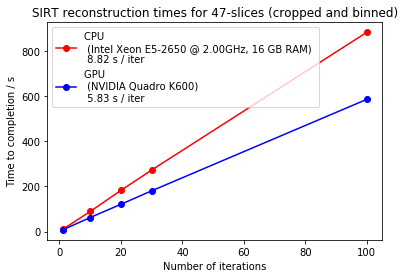

In [55]:
raw_data = hs.load(folder+name).data
raw_data -= raw_data.min()
raw_data /= raw_data.max()

In [56]:
np.shape(raw_data)

(99, 279, 325)

### Make sure the data is square array
- Since we have aligned our tilt axis vertically in the centre, we need to make sure that any cropping/padding of the image width is symmetrical

In [59]:
scopy = copy.deepcopy(raw_data)

#pad
scopy = np.pad(scopy,[(0,0),(23,23),(0,0)],mode='constant')

#crop
#scopy = scopy[:,:250,80:330]


hs.signals.Signal2D(scopy).plot()
np.shape(scopy)

(99, 325, 325)

In [60]:
raw_data = copy.deepcopy(scopy)
np.shape(raw_data)

(99, 325, 325)

In [61]:
# plot to check everything
s = hs.signals.Signal2D(raw_data)
s.plot()

In [65]:
# save final aligned data
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'fully_aligned_square.tiff'
s.save(folder+name)

Overwrite 'C:\Users\Sauron\Documents\Tomography demo\\fully_aligned_square.tiff' (y/n)?
 y


In [ ]:
raw_data = hs.load(folder+name).data

In [66]:
# get angles from previously
angles=theta

Now we configure the reconstruction algorithm

In [68]:
data = rtr.tomo_data(np.array(raw_data), angles,degrees=True,
                    tilt_axis=1, stack_dim=0)

In [69]:
vol_shape = (data.shape[0],data.shape[2],data.shape[2])

projector = data.getOperator(vol_shape=vol_shape,
                           backend='astra', GPU=True)

In [70]:
alg = rtr.TV(vol_shape, order=1)

- Maxiter should be chosen such that the gap is on the order 1e-5 by the end
- Ideally try several orders of magnitude of weight (e.g. 0.01, 0.001, 0.001) and look to see which value makes sense for your dataset. Weight is the scaling parameter for the total variation regularisation term, so lower values mean less regularisation (more noisy and more missing wedge artefacts) while higher means more regularisation (if too high, sharp edges will appear 'sanded off' in the reconstruction)

In [71]:
maxiter = 10
weight = 0.05
balance = 1
steps = 'adaptive'

recon = alg.run(data=data,op=projector, maxiter=maxiter, weight=weight,
                balance=balance, steps=steps,
                callback_freq = 10,
                callback=('primal','gap','violation','step'))[0]

if steps=='adaptive':
    print('Optimal balance was: ', (alg.s/alg.t)**.5)

 Iter   Time      primal          gap        violation       step     
   0%     9s     1.313e+05     1.000e+00          0        0.000e+00  
 100%    1m16    5.511e+03    -5.222e-01     1.543e-01     2.100e-01  

Optimal balance was:  1.0931719817767658


Compare 0 angle data with projection of reconstruction in the same direction

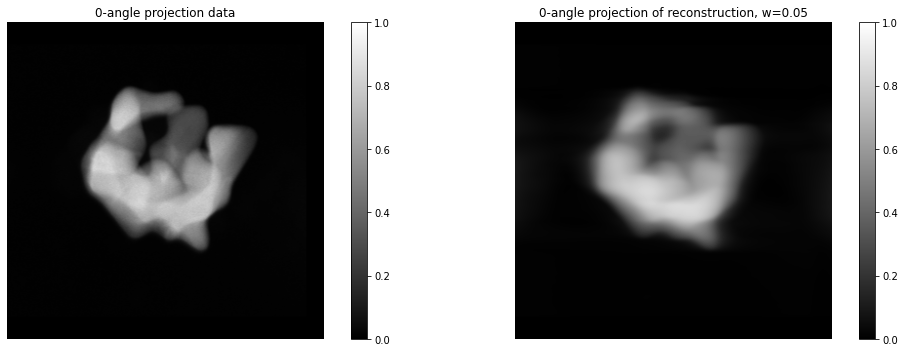

In [72]:
%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(121)
#plt.imshow(raw_data[abs(angles).argmin()], vmin=raw_data.min(), vmax=1) # plots the data collected at ~0 degree tilt
plt.imshow(raw_data[abs(angles).argmin()], vmin=raw_data.min(), vmax=1, cmap='gray')
plt.axis('off')
plt.title('0-angle projection data')
plt.colorbar()
plt.subplot(122)
plt.imshow(recon.sum(1), vmin=raw_data.min(), vmax=1, cmap='gray')
plt.title('0-angle projection of reconstruction, w=%s' % str(weight))
plt.colorbar()

plt.axis('off')
plt.tight_layout()
plt.show()


In [87]:
%matplotlib qt
reconstruction = hs.signals.Signal2D(reconflip)
reconstruction.plot()

In [86]:
# Save reconstruction
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'recon_i10_w05.tiff'

reconflip = np.swapaxes(recon,0,1)
reconstruction = hs.signals.Signal2D(reconflip)
reconstruction.change_dtype('Float32')
reconstruction.save(folder+name)

# (Basic reconstruction)

- If desired, you can also easily reconstruct using more basic reconstruction algorithms
- Use tomopy to perform reconstruction given the aligned dataset, angle values, and desired algorithm.
- Make sure that theta is in __radians__

In [74]:
import tomopy

In [36]:
# FBP (Filtered back projection)
recon = tomopy.recon(raw_data, theta*(2*np.pi)/360, algorithm='fbp')

NameError: name 'tomopy' is not defined

In [82]:
# SIRT (Simultaneous iterative reconstruction technique)
# ~100 iterations often gives a good quality, note that more is not always better
recon = tomopy.recon(raw_data, theta*(2*np.pi)/360, algorithm='sirt',num_iter = 20, accelerated=False)

Reconstructing 96 slice groups with 96 master threads...


- Compare ~0 angle data with 0 angle projection for rough indication of quality

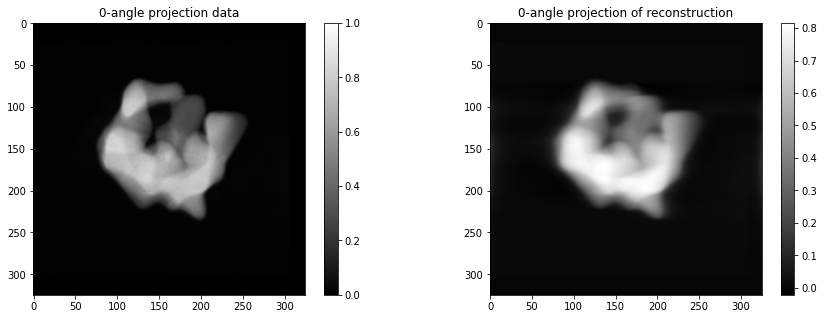

In [83]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
# find the tilt image from 0 degree tilt
plt.imshow(raw_data[abs(np.array(theta)).argmin()], vmin=raw_data.min(), vmax=1,cmap='gray')
plt.title('0-angle projection data')
plt.colorbar()

plt.subplot(122)
reconstruction = hs.signals.Signal2D(recon)
plt.imshow(reconstruction.data.sum(1),cmap='gray')#, vmin=ims.data.min(), vmax=1)
plt.title('0-angle projection of reconstruction')
plt.colorbar()

plt.show()

- Plot full reconstruction to inspect.

In [84]:
%matplotlib qt
reconstruction = hs.signals.Signal2D(recon)
reconstruction.plot()

- Save reconstruction.

In [88]:
reconstruction.save(folder+'recon_20SIRT.tiff')

Overwrite 'C:\Users\Sauron\Documents\Tomography demo\\recon_20SIRT.tiff' (y/n)?
 y


# Visualisation
- Presumably you will now want to visualise the reconstruction by some means.
- You can plot orthoslices simply using matplotlib in python.
- Avizo is a useful commercial program for analysing tomographic reconstructions (and is available on the shared computers in the electron microscopy group).
- Dragonfly is another useful commercial program similar to Avizo and is available in Earth Sciences
- ImageJ can also be used as a free alternative in many cases
- [Proviz](https://www.tandfonline.com/doi/full/10.1080/21681163.2016.1154483) is an opersource alternative.
- [Paraview](https://www.paraview.org/) is another opensource alternative.

In [5]:
from matplotlib import pyplot as plt
import hyperspy.api as hs
import numpy as np

In [90]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = 'recon_i10_w05.tiff'
fpath=folder+name

r = hs.load(fpath)

In [91]:
r.plot()

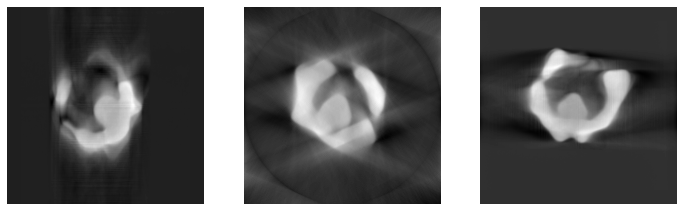

In [92]:
# Plot orthoslice

%matplotlib inline

c = int(np.shape(r)[0]/2)

f,axs=plt.subplots(ncols=3,figsize=(12,9))
axs[2].imshow(r.data[c,:,:],cmap='gray')
axs[1].imshow(r.data[:,c,:],cmap='gray')
axs[0].imshow(r.data[:,:,c],cmap='gray')
for ax in axs:
    ax.axis('off')

# Get file calibration

In [93]:
import mrcfile

In [95]:
folder = r'C:\Users\Sauron\Documents\Tomography demo\\'
name = r'raw_data_mrc.mrc'
fpath = folder+name

mrc = mrcfile.open(fpath)

In [100]:
nc = mrc.header.nx*1 # number of columns
nr = mrc.header.ny*1 # number of rows

iw = mrc.header.cella.x*1  # image width / A
ih = mrc.header.cella.y*1 # image height / A

px_x = iw/10/nc # pixel width in nm
px_y = ih/10/nr # pixel height in nm

print('\tOriginal image is (%i x %i) px, (%.2f x %.2f) nm \n \
       Original pixel size is (%.3f x %.3f) nm' % (nc,nr,iw/10,ih/10,px_x,px_y))

	Original image is (2048 x 2048) px, (550.00 x 550.00) nm 
        Original pixel size is (0.269 x 0.269) nm


In [102]:
binning_factor = 4
print("Reconstructed voxel is %.3f x %.3f x %.3f nm" %(px_x*binning_factor,px_y*binning_factor,px_x*binning_factor))

Reconstructed voxel is 1.074 x 1.074 x 1.074 nm
